In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import itertools as itt
import warnings

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read data
data = pd.read_csv('WAG_C_M.csv',sep=';',index_col=['month'],parse_dates=['month'], dayfirst=True);
data.columns=['wage'];
data.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


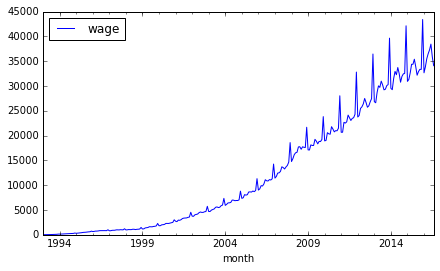

In [3]:
# take a look on raw data
plt.figure(figsize(7,4))
data.plot(y = 'wage');

Проверка стационарности и декомпозиция

Критерий Дики-Фуллера: p=0.991850


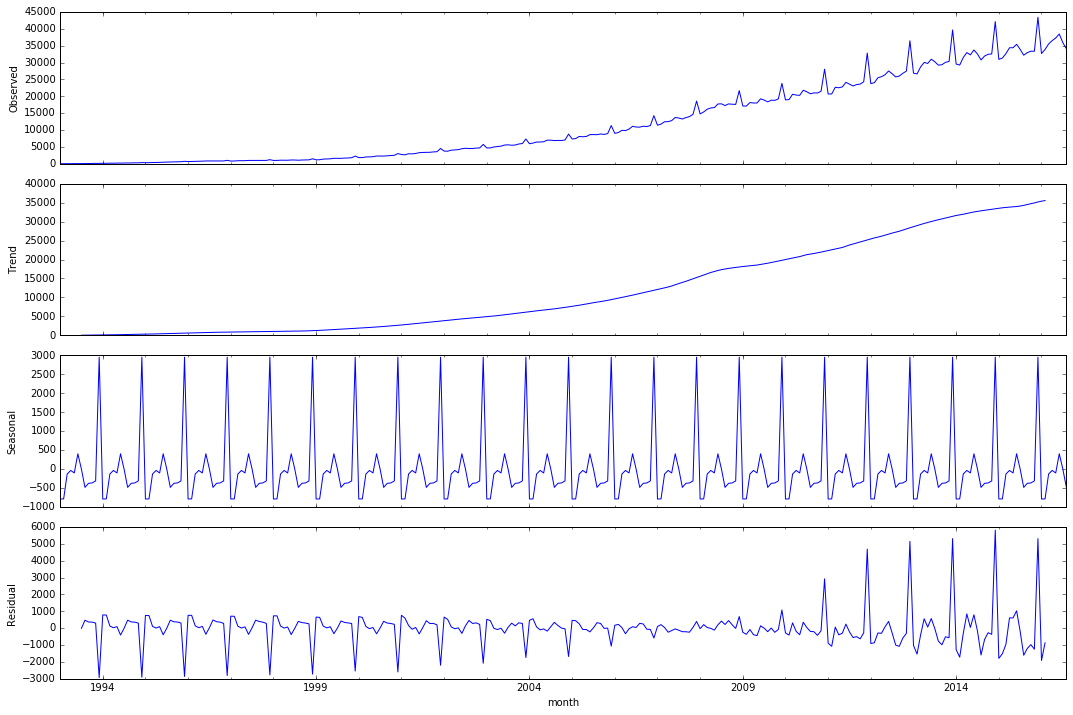

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage)[1])

Выводы: тренд и сезонность в данных очевидны. Также наблюдается изменение величины остатков со временем.

## 1) Применим преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


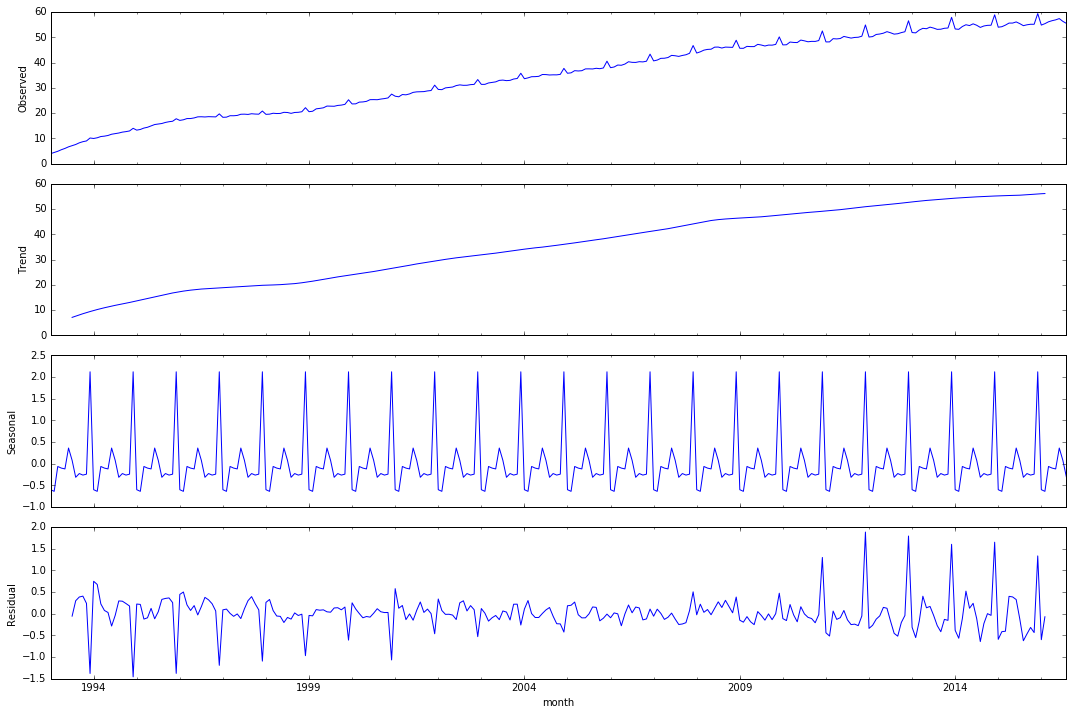

In [5]:
data['wage_box'], lmbda = stats.boxcox(data.wage);
sm.tsa.seasonal_decompose(data.wage_box).plot()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

## 2) Избавимся от 12-ти месячной сезонности

Критерий Дики-Фуллера: p=0.014697


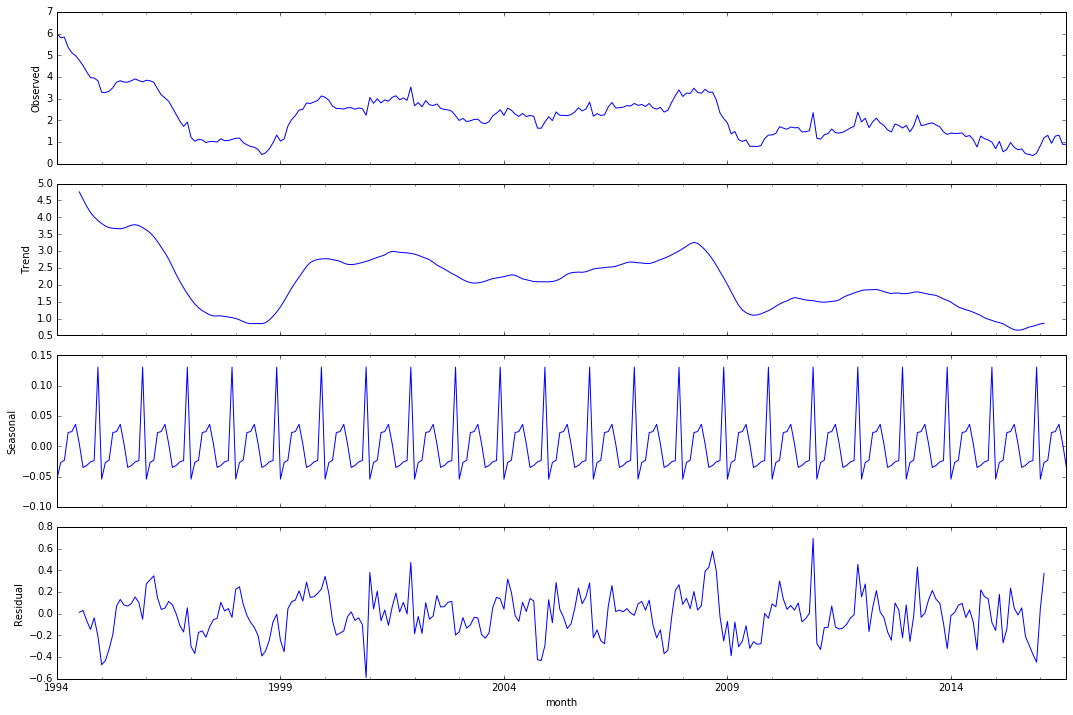

In [6]:
data['wage_season_diff'] = (data.wage_box-data.wage_box.shift(12));
sm.tsa.seasonal_decompose(data.wage_season_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_season_diff[12:])[1])

Получилось плохо - остался тренд, который стал ещё сложнее чем был раньше. Применим обычное дифференцирование.

## 3) Дифференцирование.

Критерий Дики-Фуллера: p=0.000000


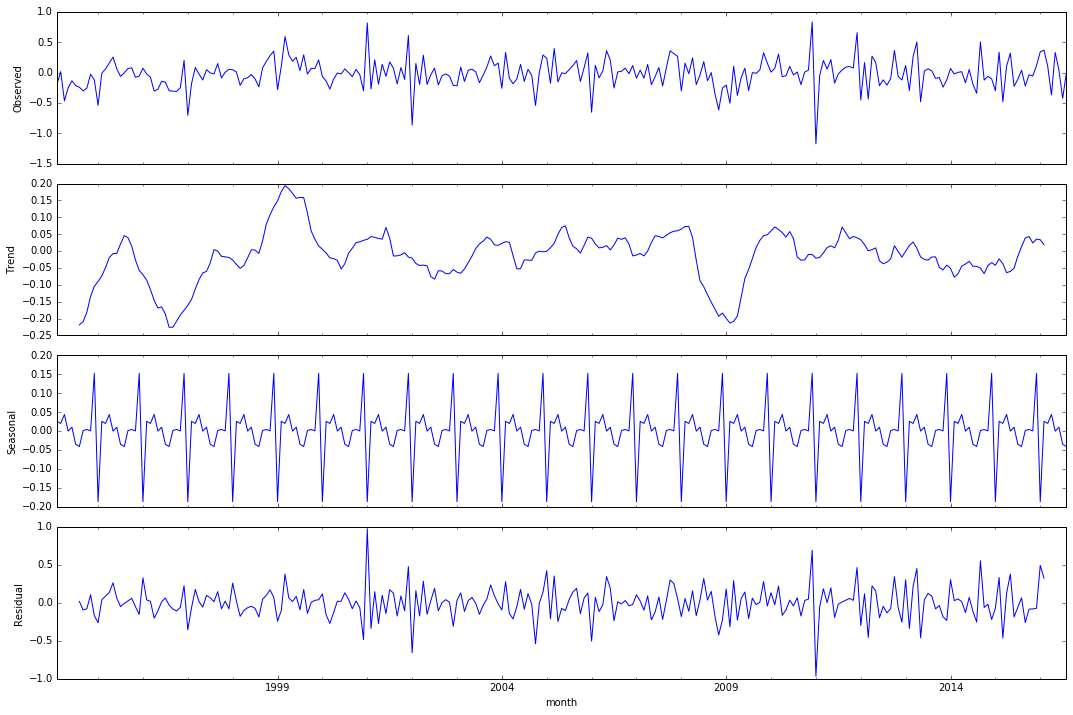

In [7]:
data['wage_diff'] = data['wage_season_diff']-data['wage_season_diff'].shift(1);
sm.tsa.seasonal_decompose(data.wage_diff[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_diff[13:])[1])

Ряд стал вполне себе стационарным.

## 4) Выбор начальных приближений.

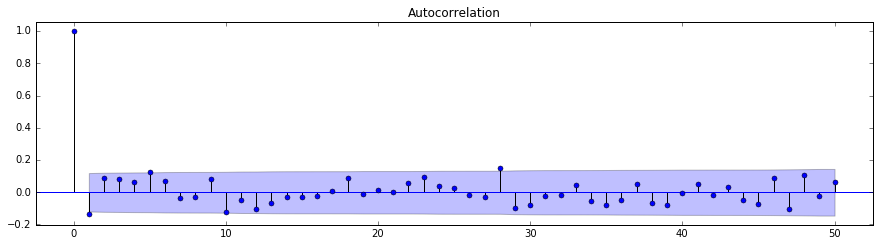

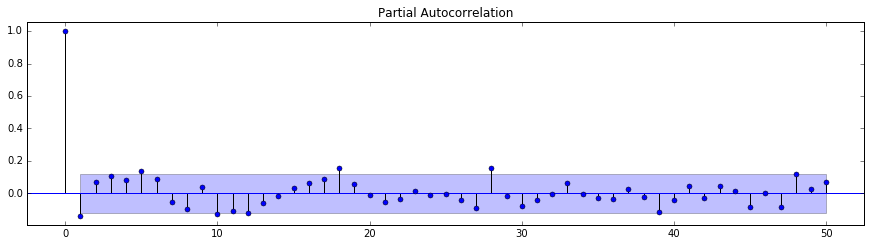

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_diff[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_diff[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Из корреляционных функций следует что в качестве начального приблежения стоит выбрать P = Q = 0, p = q = 1.

##  5) Поиск оптимальной модели

In [9]:
# define list of parameters
ps = range(0, 3)
qs = range(0, 3)
d=1

Ps = range(0, 2)
Qs = range(0, 2)
D=1

parameters = itt.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
Wall time: 22.7 s


Смотрим на 5 лучших результатов

In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
13  (1, 0, 1, 0)  0.340521
14  (1, 0, 1, 1)  0.492412
9   (0, 2, 1, 0)  0.509593
12  (1, 0, 0, 1)  0.774438
8   (0, 2, 0, 1)  0.880912


Мат. характеристика лучшей модели

In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Tue, 08 Nov 2016   AIC                              0.341
Time:                                    19:38:36   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

## 6) Проверяем полученную модель.
Смотрим на остатки. Убеждается, что среднее остатков равно нулю и ряд является стационарным.

Критерий Стьюдента: p=0.090796
Критерий Дики-Фуллера: p=0.000003


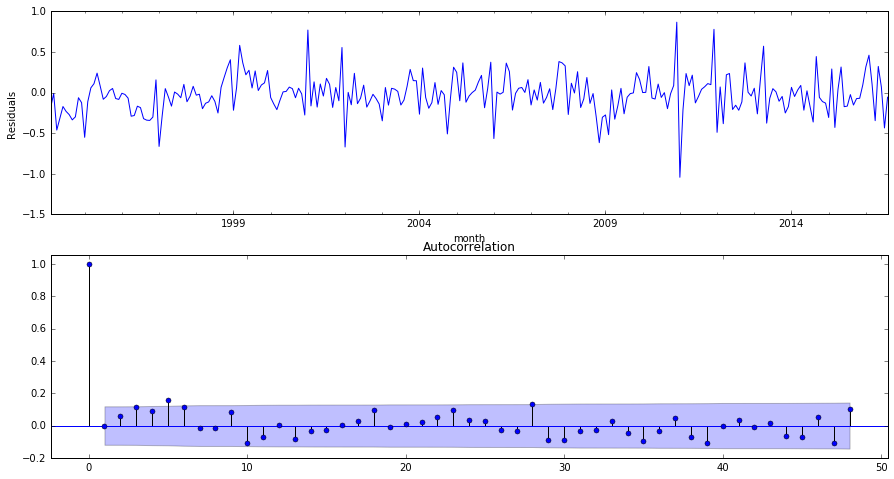

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [16]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Сравниваем временной ряд и модель

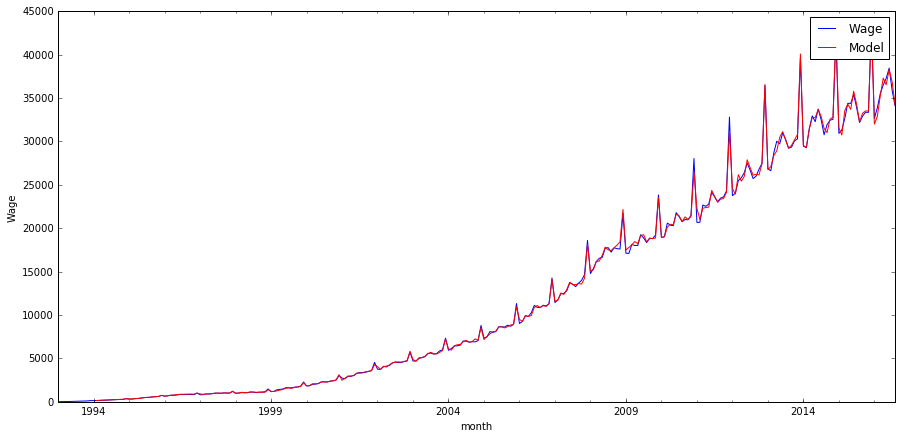

In [17]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.wage.plot()
data.model[13:].plot(color='r')
plt.ylabel('Wage')
plt.legend(['Wage','Model'])
plt.show()

## 7) Прогнозирование

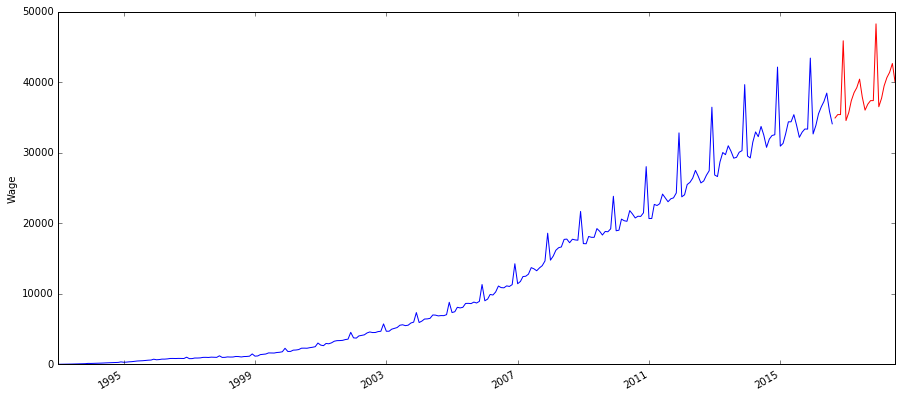

In [19]:
wage2 = data[['wage']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
wage2.wage.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()